time series forecasting github repo:

https://github.com/jiwidi/time-series-forecasting-with-python/blob/master/01-Analysis%26transforms.ipynb

https://github.com/ganesh10-india/Retail-Sales-Time-series-Forecasting/blob/main/Notebooks/Model_implimentation.ipynb

https://github.com/saziaa/Sales-Prediction-for-Pharmaceutical-Distribution-Companies-by-Time-Series-Analysis/blob/main/Applying%20TS%20models%20on%20R03.ipynb

In [1]:
import numpy as np
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib as mpl
from pylab import rcParams
import seaborn as sns
import itertools
sns.set()
%matplotlib inline
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa import api as smt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

## custom functions
import sys
sys.path.append(r"C:\Users\Admin\AI COURSE DIGICROME\Pharmaceutical Sales prediction across multiple stores")

import warnings

warnings.filterwarnings("ignore")

In [2]:
train_file = 'train.csv'

In [3]:
## loading train data using pandas library
train_df = pd.read_csv(train_file, parse_dates = True, low_memory = False)

In [4]:
train_df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [5]:
### Closed stores with no sales will not be counted for forcaset
sales_df = train_df[(train_df.Open != 0) & (train_df.Sales != 0)]

# Convert 'Date' column to datetime format
sales_df['Date'] = pd.to_datetime(sales_df['Date'])

# Group by 'Date' and sum the 'Sales' values for each unique date
sales_df = sales_df.groupby('Date', as_index=False)['Sales'].sum()


# reverse to the order: from 2013 to 2015
sales_df = sales_df.sort_index(ascending = False)

# Set 'Date' column as the index
#sales_df.set_index('Date', inplace=True)

In [9]:
sales_df = sales_df.sort_values(by='Date')
sales_df.head(7)

,Date,Sales
0,2013-01-01,97235
1,2013-01-02,6949829
2,2013-01-03,6347820
3,2013-01-04,6638954
4,2013-01-05,5951593
5,2013-01-06,143904
6,2013-01-07,10826848


In [8]:
sales_df.tail(7)

,Date,Sales
935,2015-07-25,6021666
936,2015-07-26,285865
937,2015-07-27,10707292
938,2015-07-28,9115073
939,2015-07-29,8499962
940,2015-07-30,8798854
941,2015-07-31,10109742


In [10]:
sales_df.shape

(942, 2)

In [10]:
sales_df.to_csv('rossmann_train.csv', index=False)

## Time Series Analysis of Data
**Isolate the Rossmann Store Sales dataset into time series data**


In [7]:
## Choose a specific store for analysis (optional)
sales_df = train_df[train_df["Store"] == 1]  # Example for store 1


sales_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2013-01-01,1,2,0,0,0,0,a,1
2013-01-02,1,3,5530,668,1,0,0,1
2013-01-03,1,4,4327,578,1,0,0,1
2013-01-04,1,5,4486,619,1,0,0,1
2013-01-05,1,6,4997,635,1,0,0,1


In [9]:
time_series = sales_df[['Sales']]
time_series.head()

,Sales
Date,
2013-01-01,0
2013-01-02,5530
2013-01-03,4327
2013-01-04,4486
2013-01-05,4997


## Visulization of the data
To check the nature of the data

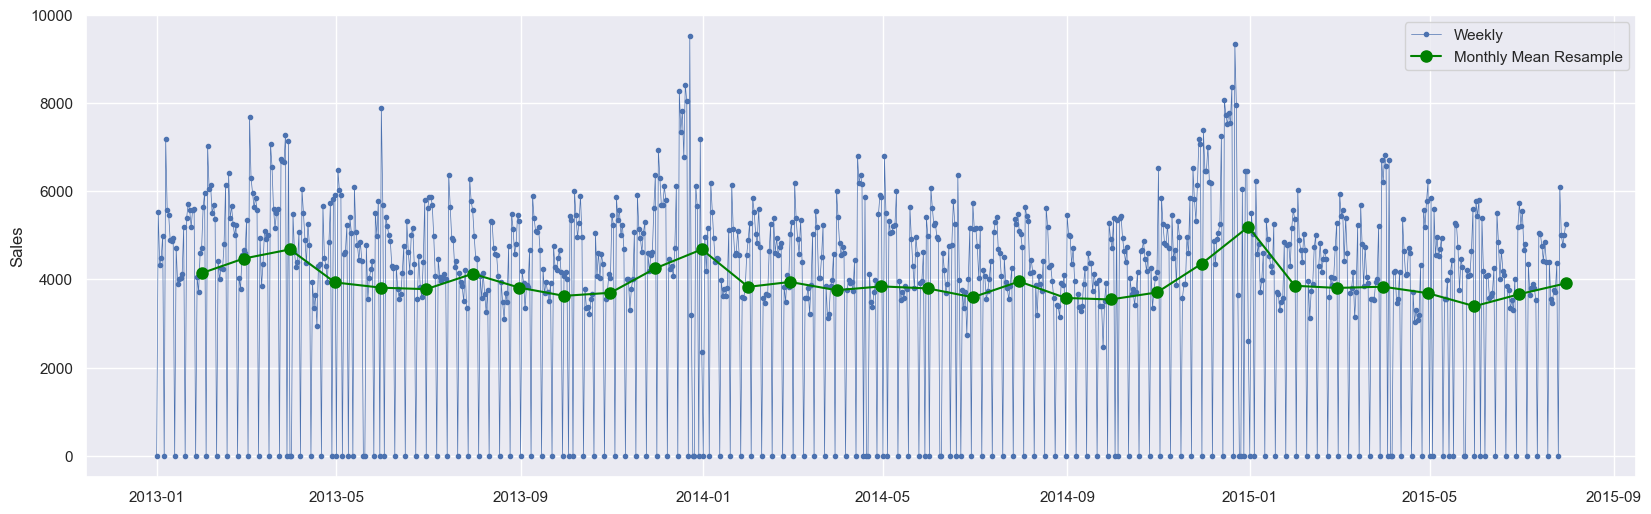

In [14]:
y = time_series['Sales']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample', color='green')
ax.set_ylabel('Sales')
ax.legend();
ax.set_ylabel('Sales')
ax.legend();

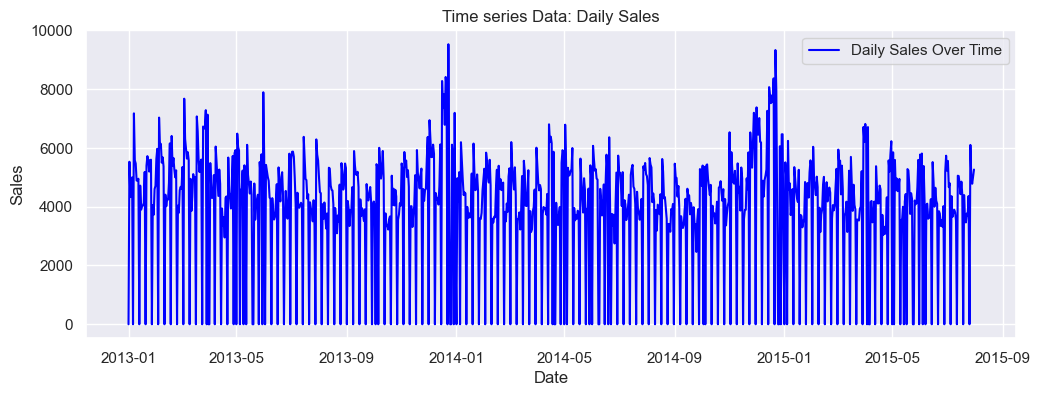

In [16]:
## Plotting the daily sales data
plt.figure(figsize=(12, 4))
plt.plot(y, label='Daily Sales Over Time', color='blue')  # Set the color to blue
plt.title('Time series Data: Daily Sales')
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

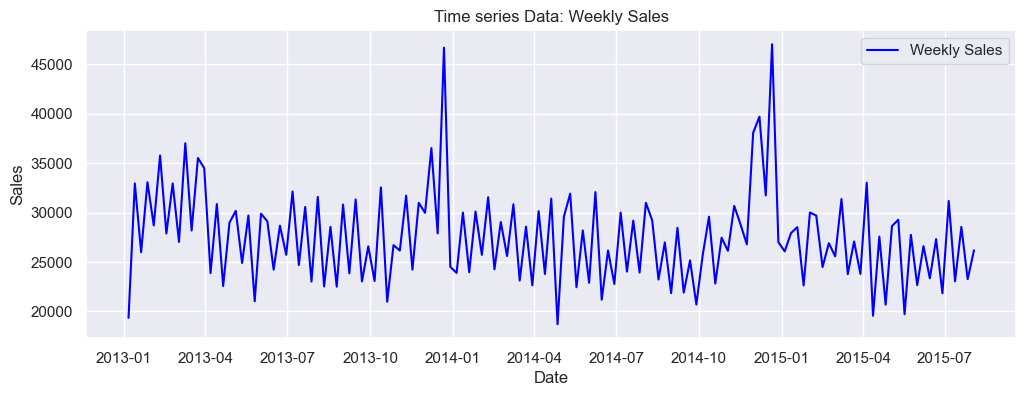

In [17]:
## Plotting the weekly sales data
weekly_sales = y.resample('W').sum()
plt.figure(figsize=(12, 4))
plt.plot(weekly_sales, label='Weekly Sales', color='blue')  # Set the color to blue
plt.title('Time series Data: Weekly Sales')
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

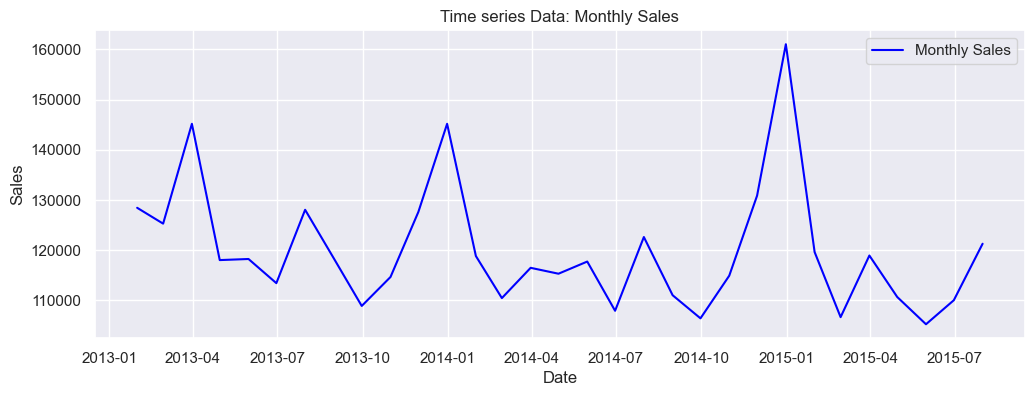

In [18]:
## Plotting the monthly sales data
monthly_sales = y.resample('M').sum()
plt.figure(figsize=(12, 4))
plt.plot(monthly_sales, label='Monthly Sales', color='blue')  # Set the color to blue
plt.title('Time series Data: Monthly Sales')
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()

<Axes: xlabel='Date'>

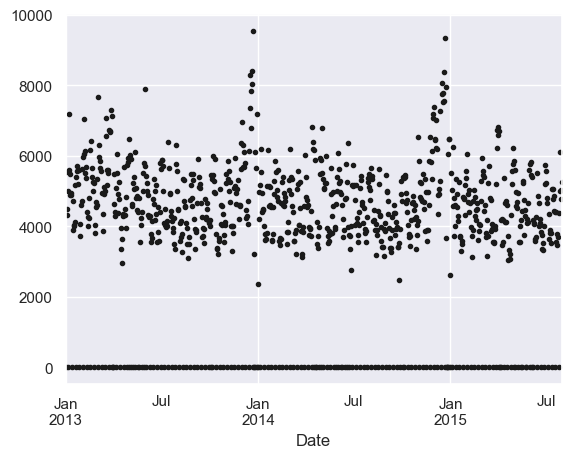

In [19]:
y.plot(style='k.')

<Axes: >

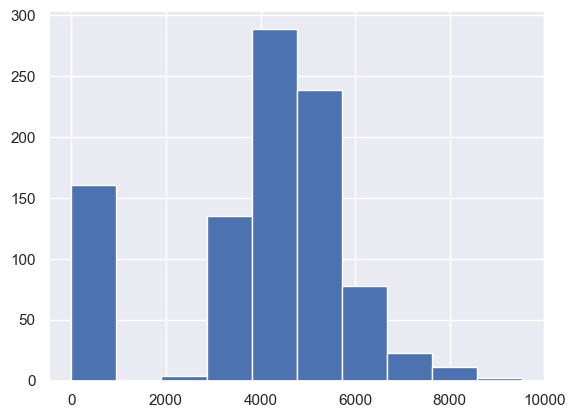

In [20]:
y.hist()

<Axes: ylabel='Density'>

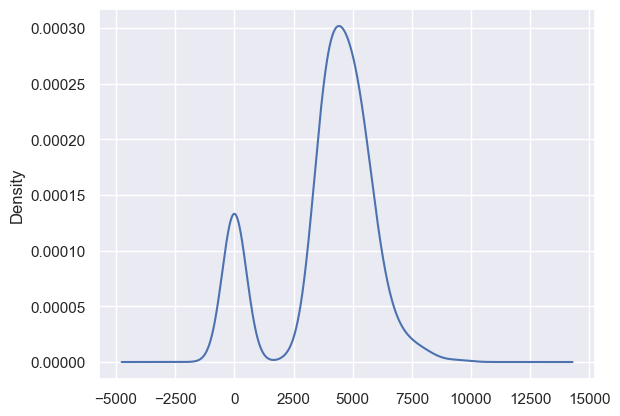

In [21]:
y.plot(kind='kde')

## Decomposing our time series

**One of the most common analysis for time series is decomposing it into multiple parts. The parts we can divide a time series into are: level, trend, seasonality and noise, all series contain level and noise but seasonality and trend are not always present**

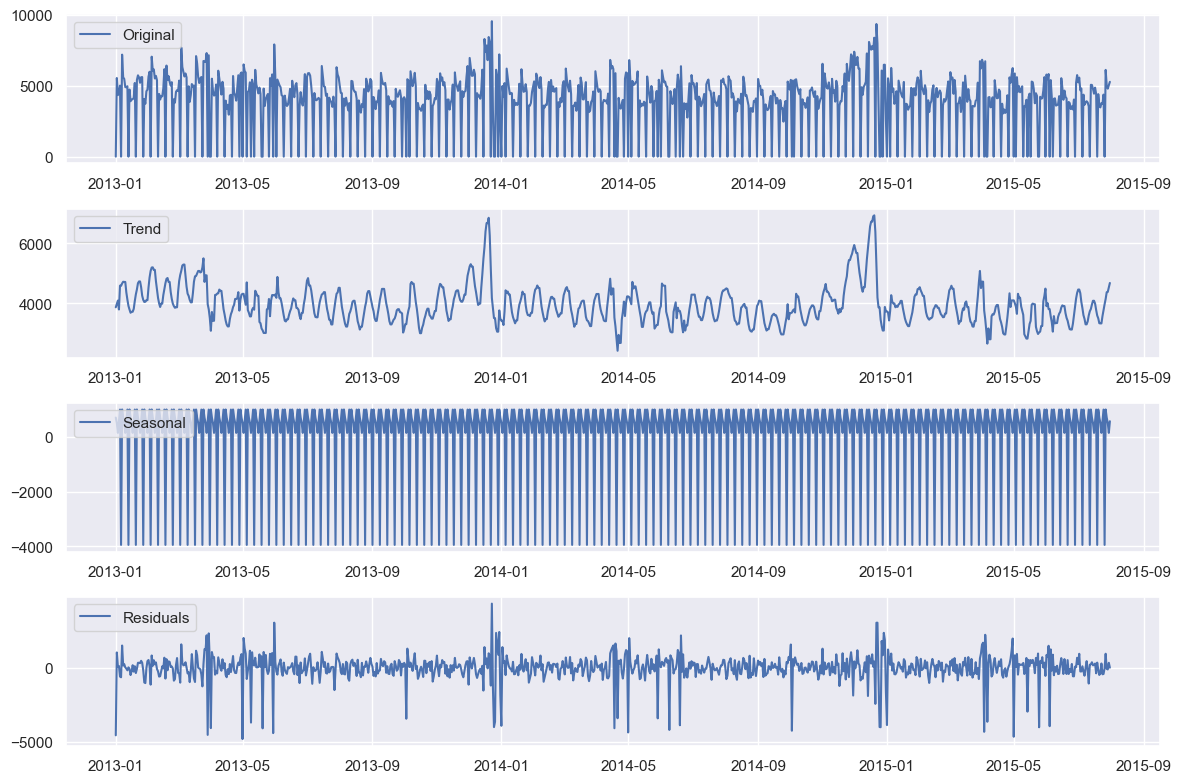

In [22]:
## Decompose the time series

decomposition = sm.tsa.seasonal_decompose(y, model = 'additive', extrapolate_trend='freq')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot the components
plt.figure(figsize=(12,8))

plt.subplot(411)
plt.plot(y, label="Original")
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(trend, label="Trend")
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(residual, label = 'Residuals')
plt.legend(loc="upper left")

plt.tight_layout()
plt.show()

### Level
**Level simply means the current value of the series once we remove trend, seasonality and the random noise**

### Trend

A trend is observed when there is an increasing or decreasing slope observed in the time series. A trend is a smooth, general, long-term, average tendency. It is not always necessary that the increase or decrease is in the same direction throughout the given period of time.

In practice, identifying a trend in a time series can be a subjective process as we are never sure if contains seasonalities or noise to it, Create line plots of your data and inspect the plots for obvious trends.

Now we will try some methods to check for trend in our series:

- Automatic decomposing
- Moving average
- Fit a linear regression model to identify trend

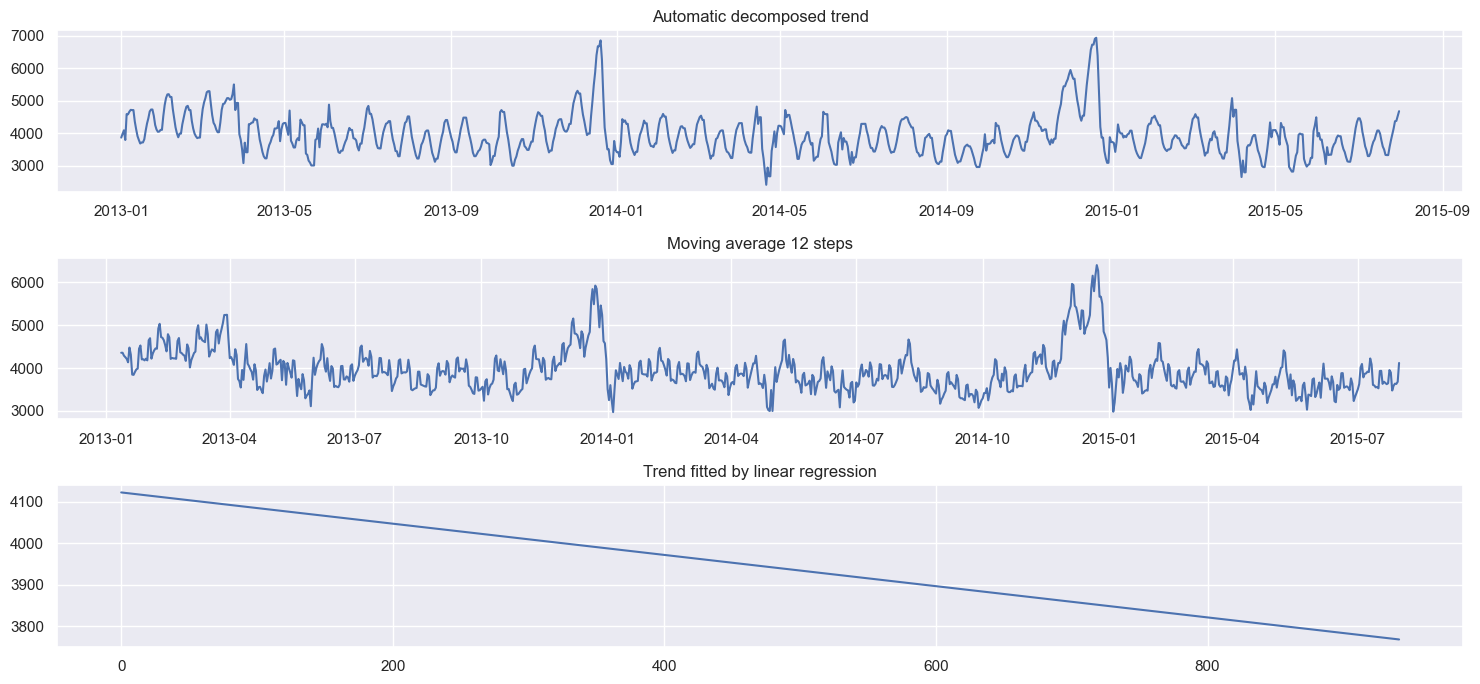

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 7))

axes[0].plot(decomposition.trend)
axes[0].set_title("Automatic decomposed trend") ## Plotting the trend component of the decomposition

mm = y.rolling(12).mean()
axes[1].plot(mm) ## Plotting the moving average with a window size of 12
axes[1].set_title("Moving average 12 steps")

X = np.arange(len(y)).reshape(-1, 1)
y = y.values
model = LinearRegression()
model.fit(X, y) 
trend = model.predict(X)
axes[2].plot(trend) ## Plotting the trend fitted by linear regression
axes[2].set_title("Trend fitted by linear regression")

plt.tight_layout()
plt.show()

## INTERPRETATION

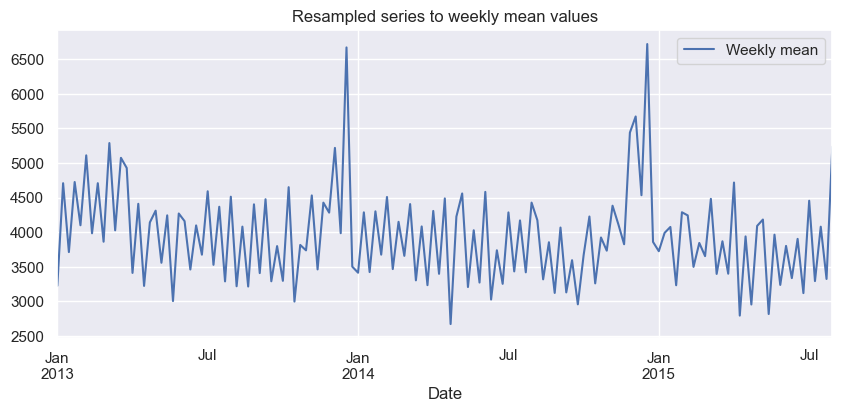

In [28]:
## looking for weekly seasonality

plt.figure(figsize=(10,4))

## Resample the sales dataframe to weekly frequency
resample = time_series.resample('W')

## Calculate the mean of each weekly resampled data
weekly_mean = resample.mean()

## Plot the weekly mean pollution values
weekly_mean.Sales.plot(label='Weekly mean')

## Set the title of the plot
plt.title("Resampled series to weekly mean values")

## Add a legend to the plot
plt.legend()

## Show the plot
plt.show()

#### Manual methods to find seasonalities

We can also try to generate a model to find the seasonalities for us. One of the most common to use is a simple polynomial model.

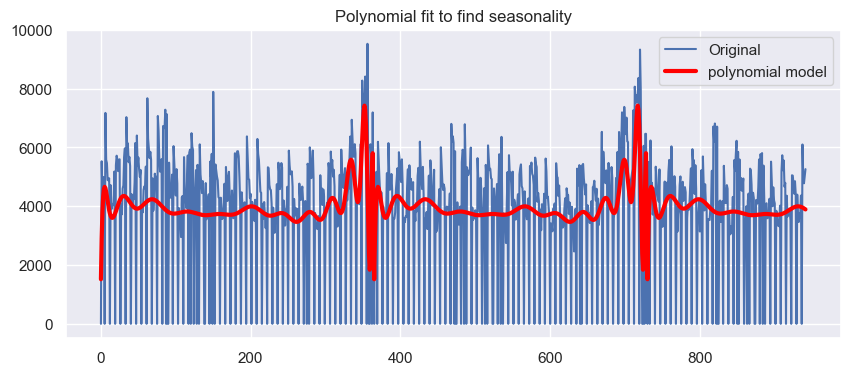

In [32]:
## fit polynomial: x^2*b1 + x*b2 + ... + bn
series = time_series['Sales'].values
X = [i % 365 for i in range(0, len(series))]
y = series
degree = 100
coef = np.polyfit(X, y, degree)
## create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)
## plot curve over original data
plt.figure(figsize=(10,4))
plt.plot(series, label='Original')
plt.plot(curve, color='red', linewidth=3, label='polynomial model', )
plt.legend()
plt.title("Polynomial fit to find seasonality")
plt.show()

**Observation:The curve appears to be a good fit for the seasonal structure in the dataset.**

### Noise

Text(0.5, 1.0, 'Mean over time')

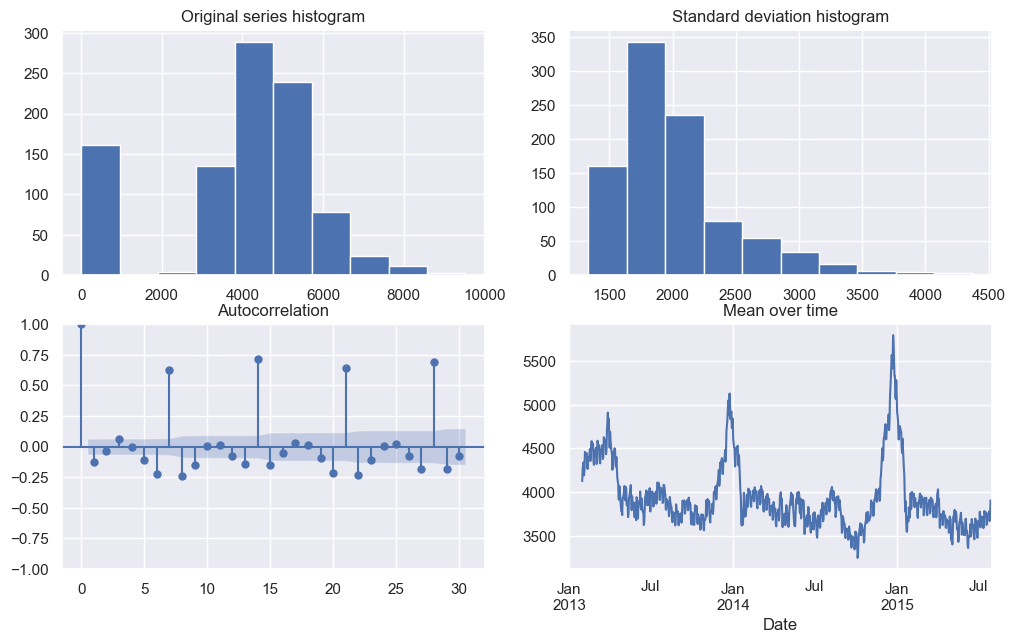

In [34]:
series = time_series['Sales'].values

fig = plt.figure(figsize=(12, 7))
layout = (2, 2)
hist_ax = plt.subplot2grid(layout, (0, 0))
ac_ax = plt.subplot2grid(layout, (1, 0))
hist_std_ax = plt.subplot2grid(layout, (0, 1))
mean_ax = plt.subplot2grid(layout, (1, 1))

time_series['Sales'].hist(ax=hist_ax)
hist_ax.set_title("Original series histogram")

plot_acf(series, lags=30, ax=ac_ax)
ac_ax.set_title("Autocorrelation")

mm = time_series['Sales'].rolling(7).std()
mm.hist(ax=hist_std_ax)
hist_std_ax.set_title("Standard deviation histogram")

mm = time_series['Sales'].rolling(30).mean()
mm.plot(ax=mean_ax)
mean_ax.set_title("Mean over time")

**Note: We can see our series do not follow a Gaussian distribution from the histogram and neither the standard deviation**

# Stationarity Check

**Stationarity is an important characteristic of time series. A time series is stationarity if it has constant mean and variance over time. Most models work only with stationary data as this makes it easier to model. Not all time series are stationary but we can transform them into stationary series in different way.**


## Check whether your time Series Data is Stationary


### Autocorrelation and Partial autocorrelation plots:

**Autocorelation plots show how correlated are values at time t with the next values in time t+1,t+2,..t+n. If the data would be non-stationary the autocorrelation values will be highly correlated with distant points in time showing possible seasonalities or trends.**

**Stationary series autocorrelation values will quickly decrease over time t. This shows us that no information is carried over time and then the series should be constant over time.**

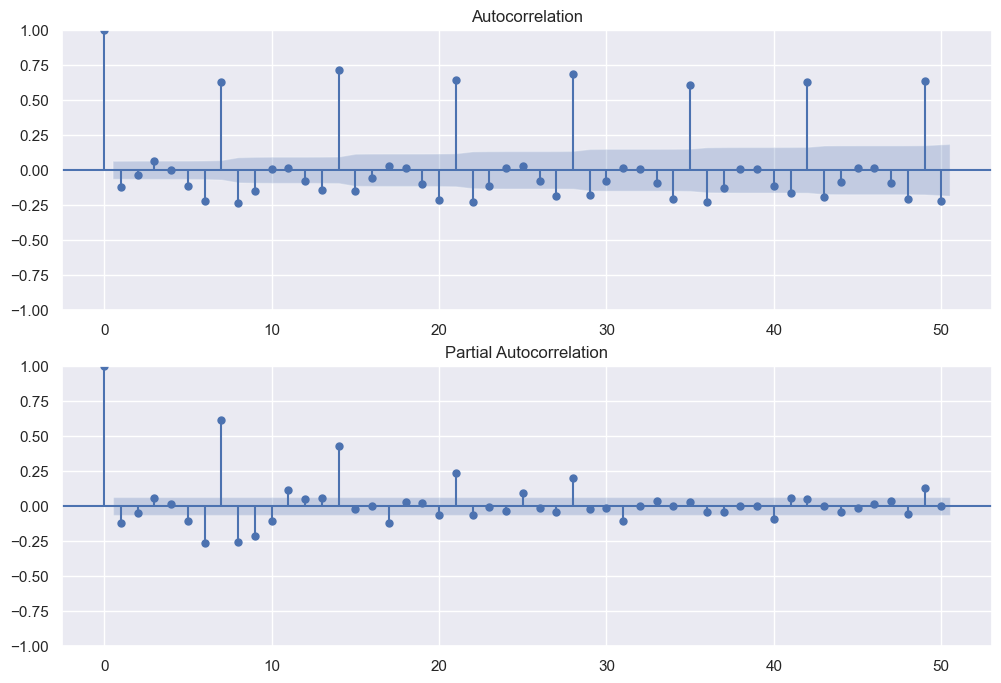

In [35]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(time_series['Sales'].iloc[13:],lags=50,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(time_series['Sales'].iloc[13:],lags=50,ax=ax2)

### Rolling means and standard deviation of our series
We were talking about how our mean and standard deviation should be constant over time in order to have a stationary time series, why not just plot this two properties?

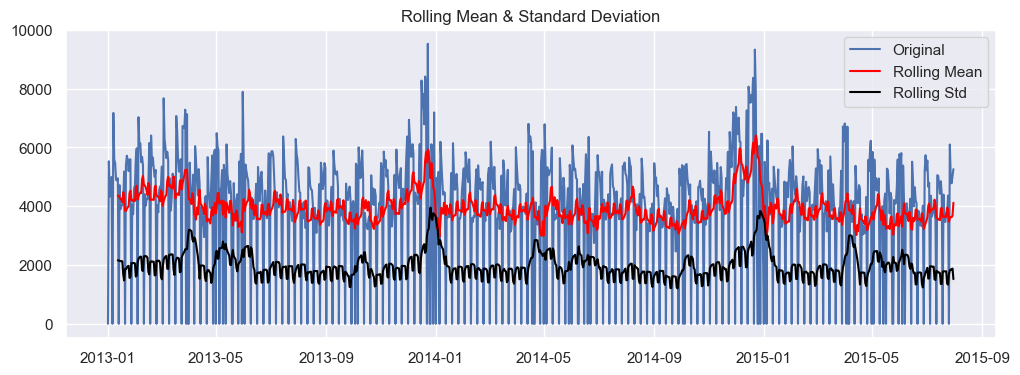

In [36]:
# Determing rolling statistics
rolmean = time_series['Sales'].rolling(window=12).mean()
rolstd = time_series['Sales'].rolling(window=12).std()

# Plot rolling statistics:
plt.figure(figsize=(12, 4))
orig = plt.plot(time_series['Sales'], label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

**We can see how our mean and standar deviation have a constant behaviour over the years, even if they change over the year this behaviour is then repeated next year. This proves us that our time series is a stationary series**

## Augmented Dickey-Fuller test

In [37]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [38]:
adfuller_test(time_series['Sales'])

ADF Test Statistic : -4.368104368168503
p-value : 0.0003378834614142389
#Lags Used : 21
Number of Observations Used : 920
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [ ]:
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(df["R06"], regression="ct", nlags="auto")

#### Here we also provide a method to quickly perform all the previous methods into one single function call and a pretty graph :)

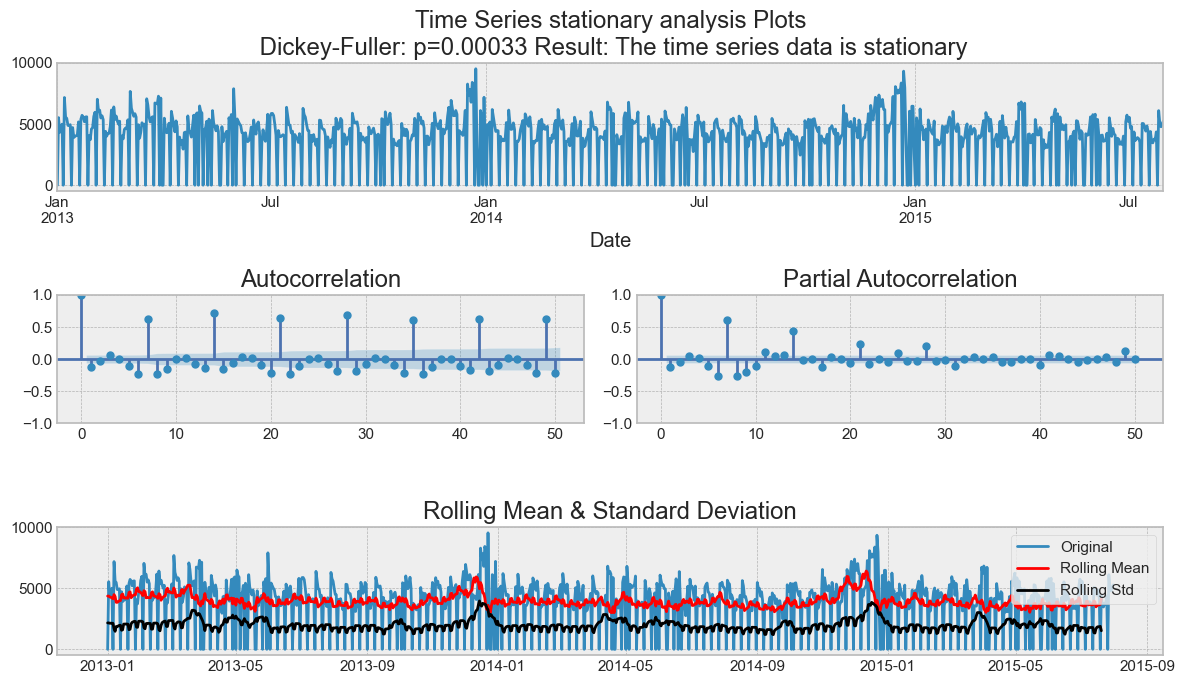

In [26]:
from statsmodels.tsa import api as smt

def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)

    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=(12, 7))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        mean_std_ax = plt.subplot2grid(layout, (2, 0), colspan=2)
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        hypothesis_result = "The time series data is stationary" if p_value <= 0.05 else "The time series data is not stationary"
        ts_ax.set_title(
            'Time Series stationary analysis Plots\n Dickey-Fuller: p={0:.5f} Result: {1}'.format(p_value, hypothesis_result))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

        rolmean = time_series['Sales'].rolling(window=12).mean()
        rolstd = time_series['Sales'].rolling(window=12).std()

        # Plot rolling statistics:
        orig = plt.plot(time_series['Sales'], label='Original')
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label='Rolling Std')
        plt.legend(loc='best')
        plt.title('Rolling Mean & Standard Deviation')


tsplot(time_series['Sales'], lags=50)

In [27]:
from datetime import datetime,timedelta

In [28]:
#test data 2015-07-01 to 2015-07-31
training_data,test_data=time_series[time_series.index<'2015-07-01'],time_series[time_series.index>='2015-07-01']

In [29]:
print(time_series.shape)
print(training_data.shape)
print(test_data.shape)

(942, 1)
(911, 1)
(31, 1)


In [48]:
# ARIMA
arima= ARIMA(training_data,order=(1,0,1))
model=arima.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  911
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -8220.589
Date:                Wed, 24 Jan 2024   AIC                          16449.177
Time:                        22:56:57   BIC                          16468.435
Sample:                             0   HQIC                         16456.529
                                - 911                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3946.8584     76.061     51.891      0.000    3797.782    4095.935
ar.L1          0.0853      0.240      0.356      0.722      -0.385       0.555
ma.L1         -0.2203      0.227     -0.972      0.331      -0.664       0.224
sigma2       4.03e+06   2.19e+05     18.408      0.000     3.6e+06    4.46e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                70.54
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.90   Skew:                            -0.68
Prob(H) (two-sided):                  0.35   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
model.aic

16449.17702440873

In [51]:
pred = model.forecast(steps=31)[0]
test_data['predict'] = pred
test_data[['Sales', 'predict']].plot(figsize=(20, 8))

KeyError: 0

In [52]:
import itertools

In [53]:
# SARIMA
p = d = q = range(0, 2) # Define the p, d and q parameters to take any value between 0 and 2

pdq = list(itertools.product(p, d, q)) # Generate all different combinations of p, q and q triplets

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [54]:
model=sm.tsa.statespace.SARIMAX(time_series['Sales'],order=(0, 1, 2),seasonal_order=(1,1,1,12))
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Sales   No. Observations:                  942
Model:             SARIMAX(0, 1, 2)x(1, 1, [1], 12)   Log Likelihood               -8404.247
Date:                              Wed, 24 Jan 2024   AIC                          16818.493
Time:                                      22:57:38   BIC                          16842.664
Sample:                                           0   HQIC                         16827.712
                                              - 942                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.1394      1.114     -1.023      0.306      -3.323       1.044
ma.L2          0.1394      0.156      0.896      0.370      -0.165       0.444
ar.S.L12      -0.0830      0.039     -2.133      0.033      -0.159      -0.007
ma.S.L12      -0.9995      1.120     -0.892      0.372      -3.195       1.196
sigma2       3.96e+06   2.19e-07   1.81e+13      0.000    3.96e+06    3.96e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                65.15
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                            -0.65
Prob(H) (two-sided):                  0.40   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.87e+28. Standard errors may be unstable.
"""

<Axes: xlabel='Date'>

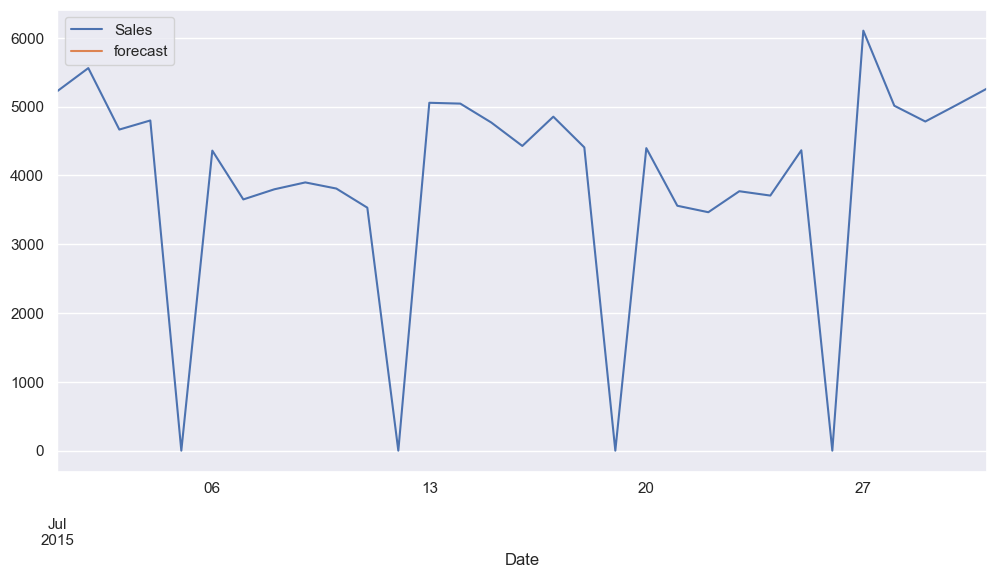

In [55]:
test_data['forecast']=results.predict(start=-42,dynamic=True)
test_data[['Sales','forecast']].plot(figsize=(12,6))

In [56]:
test_data

,Sales,predict,forecast
Date,,,
2015-07-31,5263,NaN,NaN
2015-07-30,5020,NaN,NaN
2015-07-29,4782,NaN,NaN
2015-07-28,5011,NaN,NaN
2015-07-27,6102,NaN,NaN
2015-07-26,0,NaN,NaN
2015-07-25,4364,NaN,NaN
2015-07-24,3706,NaN,NaN
2015-07-23,3769,NaN,NaN


In [57]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define the p, d, q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Define the seasonal parameters
P = D = Q = range(0, 2)
S = 12  # weekly seasonality

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[0], x[1], S) for x in list(itertools.product(P, D, Q))]

best_aic = float('inf')
best_pdq = None
best_seasonal_pdq = None
best_model = None

# Grid search for the optimal ARIMA parameters
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(time_series['Sales'],
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            results = mod.fit(disp=False)

            # Compare this model's AIC to the best AIC found so far
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
                best_model = results
        except:
            continue

print('Best SARIMA{}x{} - AIC:{}'.format(best_pdq, best_seasonal_pdq, best_aic))

Best SARIMA(1, 1, 2)x(1, 1, 1, 12) - AIC:16542.04687259075


In [61]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use the best parameters obtained from grid search
best_pdq = (1, 1, 1)
best_seasonal_pdq = (1, 1, 0, 12)  # Adjust the values based on your grid search results

# Fit the SARIMA model with the best parameters
best_model = SARIMAX(time_series['Sales'],
                     order=best_pdq,
                     seasonal_order=best_seasonal_pdq,
                     enforce_stationarity=False,
                     enforce_invertibility=False)

best_results = best_model.fit(disp=False)

# Forecast 6 weeks ahead
forecast_steps = 6*7
forecast = best_results.get_forecast(steps=forecast_steps)

# Get the predicted mean and confidence intervals
predicted_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Print the predicted mean and confidence intervals
print("Predicted Mean:")
print(predicted_mean)

print("\nConfidence Intervals:")
print(confidence_intervals)

# You can use the predicted_mean for plotting or further analysis


Predicted Mean:
942    5314.248796
943    5256.197864
944    5354.668374
945    5443.101317
946    2576.446901
947    6111.565264
948    2245.487826
949    4495.484952
950    4241.340535
951    4109.918713
952    5104.189756
953      13.818361
954    5132.181631
955    5067.128509
956    5118.299464
957    5472.005852
958    4214.432369
959    6700.975209
960    1045.061809
961    4780.496869
962    4387.458157
963    4241.123474
964    5348.264407
965      20.164463
966    5244.452555
967    5183.185857
968    5259.933980
969    5470.194127
970    3342.512396
971    6396.070973
972    1708.008847
973    4640.195437
974    4322.263620
975    4183.993045
976    5230.099745
977      30.551178
978    5197.560572
979    5134.246371
980    5197.163676
981    5484.992176
982    3827.820254
983    6574.765870
Name: predicted_mean, dtype: float64

Confidence Intervals:
     lower Sales   upper Sales
942 -1723.601192  12352.098785
943 -1798.531425  12310.927153
944 -1700.240582  12409.577331
94

In [64]:
# ## plot the forecast
# plt.figure(figsize=(10,6))
# plt.plot(time_series, label='Actual')
# plt.plot(forecast_index, predicted_mean, label='Forecast')
# plt.xlabel('Month')
# plt.ylabel('Passengers')
# plt.title('Airline Passengers Forecast')
# plt.legend()
# plt.show()

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


# Fit an ARIMA model to your data
model = ARIMA(Sales, order=(p, d, q)) 
model_fit = model.fit()

# Forecast future values
future_dates = pd.date_range(start=Sales.index[-1], periods=6*7, freq='D')
forecast = model_fit.get_forecast(steps=len(future_dates))
forecast_index = forecast.index

# Plot the forecasted values
plt.figure(figsize=(12, 6))
plt.plot(Sales.index, Sales.values, label='Observed')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast_index, forecast.conf_int().iloc[:, 0], forecast.conf_int().iloc[:, 1], color='pink', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

# Print the forecasted values for the last 7 days
print(forecast.predicted_mean.tail(7))

NameError: name 'Sales' is not defined

In [ ]:
Isolate the dataset into time series data and Visualize the Time Series Data

Check whether your time Series Data is Stationary or not?

Check for autocorrelation and partial autocorrelation of your data with analytical comment on outcomes

Construct the ARIMA Model or Seasonal ARIMA based on the data

Use the model to forecast sales in all their stores across several cities six weeks ahead of time.

Transform the time series data into supervised learning data by creating a new y(target) column

Scale your data in the (-1, 1) range

Build a LSTM Regression model to predict the next sale.